# Le Petite Manuel: Introduction to Hidden Markov Models

This notebook introduces the theory behind HMMs and explains why they require very specific data properties.

**Why does it matter for my project?**
- HMMs are designed for **temporal sequential data** with **hidden causal states**
- Network traffic data often violates these assumptions
- Understanding *when* HMMs fail is as important as knowing when they work

**What you'll learn**:
1. Markov Chains: The foundation (memory-1, stationarity)
2. HMMs: Adding hidden states + observations
3. `hmmlearn` library: Python implementation
4. Why network traffic, essentially, breaks fundamental assumptions

---

## What are Markov Chains?

Markov Chain is a sequence of states where the next state depends only on the current state, not the past.

### Fundamental Assumptions

**1. First-Order Markov Property (Memory-1):** the future depends only on the present, not the entire history.
$$P(X_t | X_{t-1}, X_{t-2}, \dots, X_1) = P(X_t | X_{t-1})$$


**2. Stationarity:** transition probabilities don't change over time.
$$P(X_t = j | X_{t-1} = i) = P(X_s = j | X_{s-1} = i) \quad \forall t, s$$

### Example: Weather Model
- States: {Sunny, Rainy}
- Transition matrix $A$:

  |    | Sunny | Rainy|
  |----|----|----|
  |Sunny|  0.8 |   0.2|
  |Rainy | 0.3  |  0.7|

How to read? If today is Sunny, tomorrow has 80% chance of Sunny, 20% of Rainy

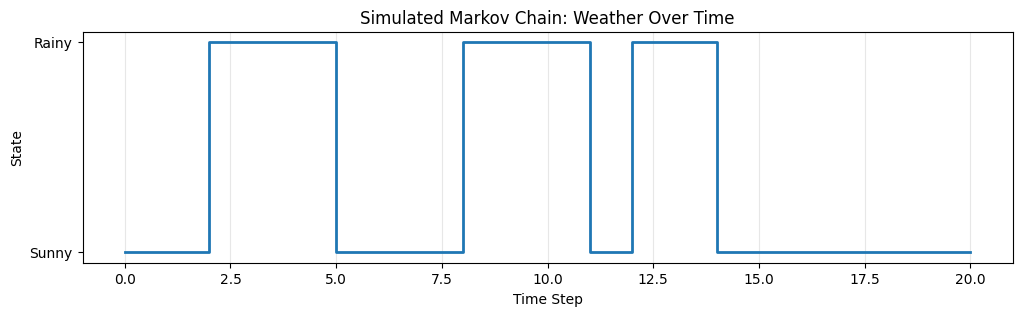

Sequence: ['Sunny', 'Sunny', 'Rainy', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Rainy', 'Rainy']...


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# transition matrix
A = np.array([[0.8, 0.2],   # Sunny -> {Sunny, Rainy}
              [0.3, 0.7]])   # Rainy -> {Sunny, Rainy}

states = ['Sunny', 'Rainy']

# simulate a sequence
current_state = 0  # start with Sunny
sequence = [current_state]
np.random.seed(42)

for _ in range(20):
    current_state = np.random.choice([0, 1], p=A[current_state])
    sequence.append(current_state)

# plot
plt.figure(figsize=(12, 3))
plt.step(range(len(sequence)), sequence, where='post', linewidth=2)
plt.yticks([0, 1], states)
plt.xlabel('Time Step')
plt.ylabel('State')
plt.title('Simulated Markov Chain: Weather Over Time')
plt.grid(axis='x', alpha=0.3)
plt.show()

print(f"Sequence: {[states[s] for s in sequence[:10]]}...")

## What are Hidden Markov Models (HMMs) ?

What if we can't observe the states directly, only some indirect signals?

### HMM Structure
- **Hidden states**: The true underlying states (e.g., "Market Regime: Bull/Bear")
- **Observations**: What we actually see (e.g., "Stock returns: +5%, -2%")

An HMM adds emission probabilities $B$: how likely each observation is given the hidden state

### A Pinch of Math
HMM is defined by $\lambda = (A, B, \pi)$:

1. **Transition Matrix** $A = \{a_{ij}\}$: $a_{ij} = P(q_{t+1} = s_j \mid q_t = s_i)$

2. **Emission Matrix** $B = \{b_j(k)\}$: $b_j(k) = P(O_t = k \mid q_t = s_j)$

3. **Initial Distribution** $\pi_i$: $\pi_i = P(q_1 = s_i)$

### Two Fundamental Independence Assumptions

**1. Markov Assumption** (same as before): $P(q_t \mid q_{t-1}, q_{t-2}, \dots, q_1) = P(q_t \mid q_{t-1})$

**2. Output Independence**: $P(O_t \mid q_t, q_{t-1}, O_{t-1}, \dots) = P(O_t \mid q_t)$

Observations depend ONLY on the current hidden state, not on history.

## What are Hidden Markov Models (HMMs) ?
An HMM is fully determined by the following components, denoted as $\lambda = (A, B, \pi)$:

1.  **Hidden States ($S$):** The set of distinct states $S = \{s_1, s_2, \dots, s_N\}$.
    * *NB:* In this project, these represent the "hidden" status of the network (e.g., "Secure" vs. "Under Attack")
2.  **Observations ($O$):** The set of observable symbols $O = \{o_1, o_2, \dots, o_M\}$ (or continuous vectors)
3.  **State Transition Probability Matrix ($A$):** The probability of moving from state $i$ to state $j$
  $$A = \{a_{ij}\}$$
  $$a_{ij} = P(q_{t+1} = s_j \mid q_t = s_i)$$
4.  **Emission Probability Matrix ($B$):** The probability of observing $k$ while in state $j$
  $$B = \{b_j(k)\}$$
  $$b_j(k) = P(O_t = k \mid q_t = s_j)$$
5.  **Initial State Distribution ($\pi$):** The probability of starting in state $i$
  $$\pi_i = P(q_1 = s_i)$$

### Example: Market Regime Switching

Hidden States: {Low Volatility, High Volatility}
- Low Vol: Returns fluctuate gently (std = 0.5)
- High Vol: Returns swing wildly (std = 3.0)

Observations are continuous stock returns (e.g., +2.3%, -1.5%, +0.8%)

The market alternates between calm and turbulent periods. The regime (calm/turbulent) is the hidden state. It can't be observed directly, only by the resulting price movements.

The goal is to infer which regime the market is in at each time step based only on observing the returns.
```
    Hidden:   Low Vol -> Low Vol -> High Vol -> High Vol -> Low Vol -> ...
                 |         |           |           |           |
                 V         v           v           v           v
    Observed:  +0.3%     -0.2%       +4.1%       -3.8%       +0.5%   ...
               (calm)   (calm)       (vol)       (vol)       (calm)
```

In [2]:
%pip install hmmlearn

In [3]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import matplotlib.pyplot as plt

# define model parameters
n_states = 2  # low and high volatility

# transition probabilities
A = np.array([[0.9, 0.1],   # low vol -> {low vol, high vol}
              [0.1, 0.9]])   # high Vol -> {high vol, low vol}

# initial distribution
pi = np.array([0.5, 0.5])

# create and configure model
model = GaussianHMM(n_components=n_states, covariance_type='diag', random_state=42)
model.startprob_ = pi
model.transmat_ = A

# emission parameters (Gaussian distributions)
model.means_ = np.array([[0.0],    # low vol: mean return = 0%
                         [0.0]])    # high vol: mean return = 0%

model.covars_ = np.array([[0.25],  # low vol: std = 0.5
                          [9.0]])   # high vol: std = 3.0

# generate synthetic data
X, Z = model.sample(200, random_state=42)

print("Generated 200 timesteps of market returns")
print("\nFirst 10 hidden states:", Z[:10])
print("First 10 observations:", X[:10].flatten().round(2))
print("\nKey: 0 = Low Volatility, 1 = High Volatility")

Generated 200 timesteps of market returns

First 10 hidden states: [0 0 0 0 0 0 0 0 0 0]
First 10 observations: [-0.56  0.16  0.14  0.51 -0.29 -0.26 -1.31  0.48 -0.21 -0.37]

Key: 0 = Low Volatility, 1 = High Volatility


State prediction accuracy: 93.50%


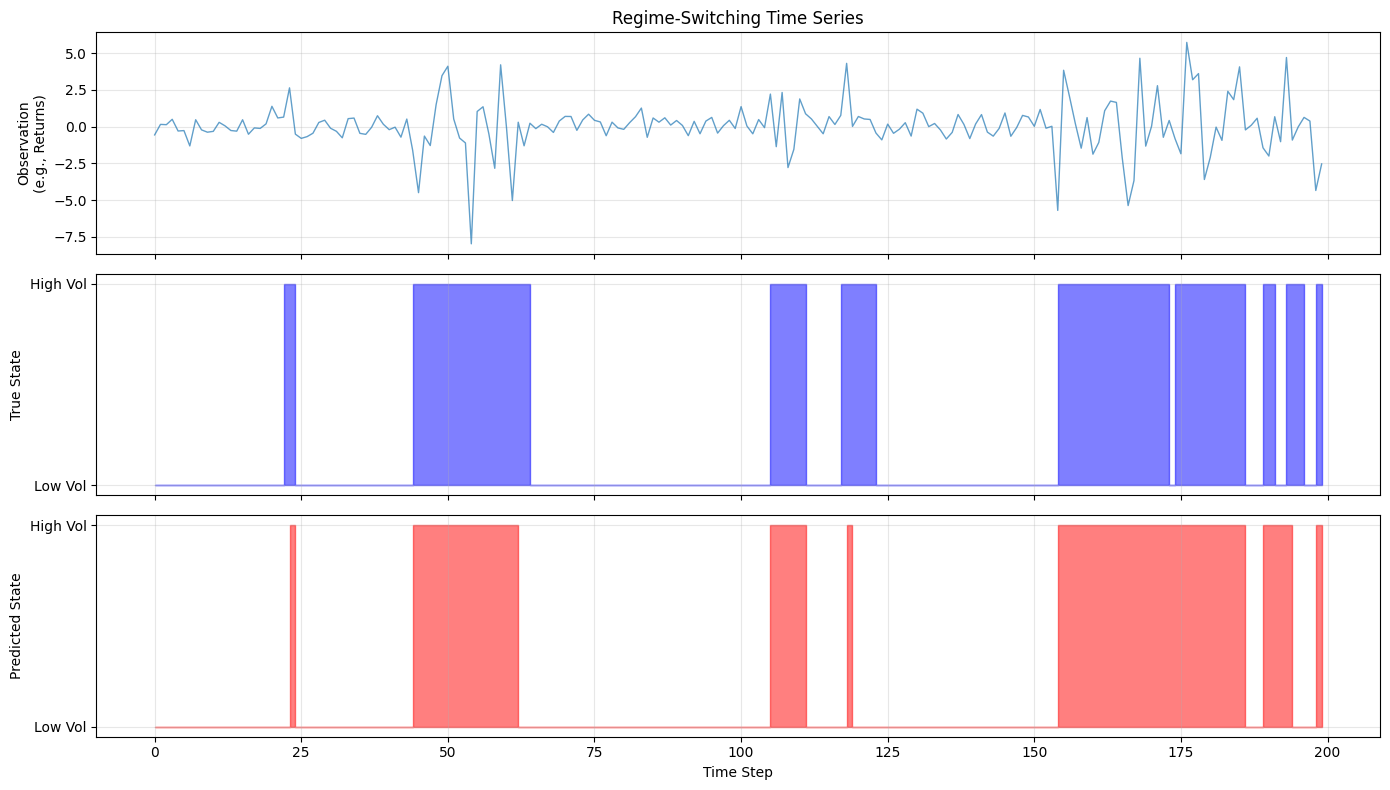

In [4]:
from hmmlearn.hmm import GaussianHMM

# low volatility regime: mean=0, std=0.5
# high volatility regime: mean=0, std=3.0

model = GaussianHMM(n_components=2, covariance_type='diag', random_state=42)

# manually set parameters for clear regimes
model.startprob_ = np.array([0.5, 0.5])
model.transmat_ = np.array([[0.9, 0.1],   # stay in regime 90% of time
                            [0.1, 0.9]])
model.means_ = np.array([[0.0], [0.0]])
model.covars_ = np.array([[0.25], [9.0]])  # low vs high variance

# generate data
X, Z = model.sample(200)

# predict
predicted = model.predict(X)
accuracy = np.mean(Z == predicted)

print(f"State prediction accuracy: {accuracy:.2%}")

# visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# observations
axes[0].plot(X, alpha=0.7, linewidth=1)
axes[0].set_ylabel('Observation\n(e.g., Returns)')
axes[0].set_title('Regime-Switching Time Series')
axes[0].grid(alpha=0.3)

# let's have our true states
axes[1].fill_between(range(len(Z)), 0, Z, alpha=0.5, color='blue', step='post')
axes[1].set_ylabel('True State')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Low Vol', 'High Vol'])
axes[1].grid(alpha=0.3)

# and our predicted states
axes[2].fill_between(range(len(predicted)), 0, predicted, alpha=0.5, color='red', step='post')
axes[2].set_ylabel('Predicted State')
axes[2].set_xlabel('Time Step')
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Low Vol', 'High Vol'])
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Three Fundamental HMM Problems

To use HMMs in practice, we solve three algorithmic problems:

### **1. Evaluation. How likely is this sequence?**

Given: Model $\lambda$ and observations $O$  

Find: $P(O \mid \lambda)$ (likelihood of observing this sequence)  

Algorithm: Forward Algorithm

Use in this project: Low likelihood -> anomaly

### **2. Decoding. What states caused this?**
Given: Model $\lambda$ and observations $O$  

Find: Most likely hidden state sequence $Q^*$  

Algorithm: Viterbi Algorithm  

Use in this project: State inference (e.g., "Was the network under attack at time t?")

### **3. Learning. Find the best model**
Given: Observations $O$ and number of states  

Find: Parameters $\lambda^* = (A, B, \pi)$ that maximize $P(O \mid \lambda)$  

Algorithm: Baum-Welch (EM algorithm)  

Use in this project: Train model on "normal" behavior

## `hmmlearn` Library

`hmmlearn` implements all three problems and uses API similar to sk-learn:

### Core Classes
- **`GaussianHMM`**: Continuous observations (e.g., temperature readings)
- **`CategoricalHMM`**: Discrete observations (e.g., coin flips)
- **`GMMHMM`**: Gaussian Mixture emissions (more flexible)

### Key Methods
* `fit(X)`: train model parameters (Problem 3)
* `score(X)`: log-likelihood of sequence (Problem 1)
* `predict(X)`: most likely hidden states (Problem 2)


### Important Parameters
- **`n_components`**: number of hidden states
- **`covariance_type`**: `'diag'`, `'full'`, `'tied'`, `'spherical'`
- **`n_iter`**: max EM iterations
- **`random_state`**: reproducibility

In [5]:
from hmmlearn.hmm import GaussianHMM

# simulate regime-switching data
np.random.seed(0)
regime1 = np.random.normal(loc=0, scale=1, size=(100, 1))   # low volatility
regime2 = np.random.normal(loc=0, scale=3, size=(100, 1))   # high volatility

# concatenate and create sequences
X_train = np.vstack([regime1, regime2, regime1])
lengths = [100, 100, 100]  # three sequences

# train GaussianHMM
model = GaussianHMM(n_components=2, covariance_type='diag', n_iter=100, random_state=42)
model.fit(X_train, lengths)

print("Model converged:", model.monitor_.converged)
print("Number of iterations:", model.monitor_.iter)
print("\nLearned Parameters:")
print("Means:", model.means_.flatten())
print("Variances:", np.diag(model.covars_[0]), np.diag(model.covars_[1]))

Model converged: True
Number of iterations: 27

Learned Parameters:
Means: [0.05980798 0.24603896]
Variances: [1.01587659] [9.63492176]


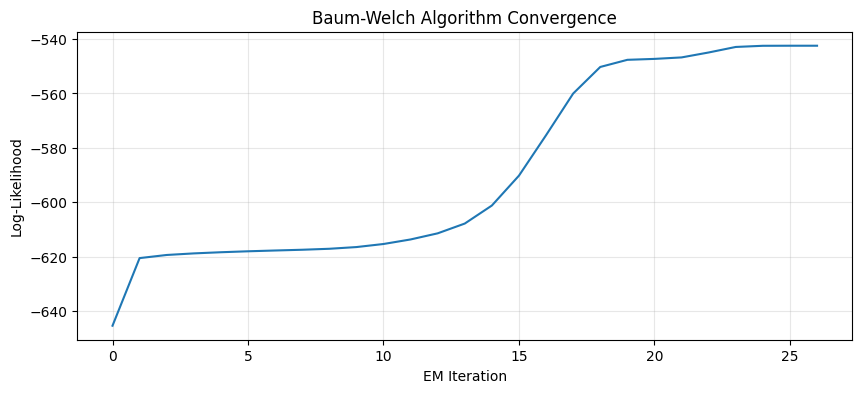


Log-likelihood of test sequence: -66.22
(Higher = more typical of training data)


In [6]:
# plot convergence
plt.figure(figsize=(10, 4))
plt.plot(model.monitor_.history)
plt.xlabel('EM Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Baum-Welch Algorithm Convergence')
plt.grid(alpha=0.3)
plt.show()

# score new sequence
X_test = np.random.normal(loc=0, scale=1, size=(50, 1))
log_likelihood = model.score(X_test)
print(f"\nLog-likelihood of test sequence: {log_likelihood:.2f}")
print("(Higher = more typical of training data)")

## What if HMM Assumptions Are Broken?

Why do HMMs struggle with anomaly detection in network traffic?

**Problem 1.** HMMs require **sequential dependencies** where $X_t$ depends on $X_{t-1}$

Network logs (e.g., the inital dataset UNSW-NB15) have each row as an independent connection record. There is no temporal ordering between rows. E.g. row 100 has NO causal relationship to row 101

For time-series aggregates (e.g., like CESNET, dataset I suggested with hourly stats), each row is a traffic summary for hour $t$. Hour $t$ correlates with hour $t-1$, so true temporal structure exists.

What does it mean? You cannot artificially "chunk" independent records into sequences and expect HMMs to work properly. The model will learn feature distributions, not state transitions.


**Problem 2.** HMMs require **interpretable hidden states** that generate observations.

It means that some domains are good for HMM. E.g. for speech, hidden states are phonemes that generate audio signals. Or in finance where hidden states are bull/bear regimes -> generate returns.

But for network traffic, what ardo we consider "hidden states"? "Normal" vs "Attack" are labels, not latent causes. Attacks are distribution shifts, not state transitions. So there is no clear generative process like "State X generates traffic pattern Y"

This means that even with proper time-series data, network traffic lacks the causal structure HMMs model.

Small note: HMMs perform best with low-dimensional observations (1-10 features) since for higher dimensions, emission probability matrices become intractable and EM algorithm struggles to converge meaningfully.

## Key Takeaways

1. **Markov Chains** require:
   - Sequential data (order matters)
   - Memory-1 property (we only care about the last state)
   - Stationarity (transitions don't change)

2. **HMMs** add:
   - Hidden causal states
   - Observable emissions generated by states
   - Output independence assumption

3. **`hmmlearn`** provides:
   - `fit()`: learn parameters (Baum-Welch)
   - `score()`: evaluate likelihood (Forward algorithm)
   - `predict()`: decode states (Viterbi)

4. **When HMMs break**: Network traffic has all three problems :(
   - Non-sequential data (independent samples)
   - No interpretable hidden states
   - High dimensionality



### What's Next?

In the example notebook, where I try HMMs on two network datasets, show empirically why they fail, demonstrate that "negative results" teach us about model limitations, and Suggest better alternatives (Isolation Forest, Autoencoders)

Let's open `HMMlearn_example.ipynb` next!

# References and Useful Resources


- Rabiner, L. R. (1989). "A tutorial on hidden Markov models and selected applications in speech recognition." *Proceedings of the IEEE*.
- Murphy, K. P. (2012). *Machine Learning: A Probabilistic Perspective*. MIT Press. Chapter 17.
- `hmmlearn` documentation: https://hmmlearn.readthedocs.io/
- Scikit-learn preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

- UNSW-NB15: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15
- CESNET-TimeSeries24: https://zenodo.org/records/13382427

---

If you liked this topic and would like to learn more, I highly recommend these videos:
- [Markov Chains Part 1](https://youtu.be/i3AkTO9HLXo?si=Fa-sYiIRnDVDCOWV)
- [Markov Chains Part 2](https://youtu.be/VNHeFp6zXKU?si=NEd3kxSm21aety6F)
- [Markov Chains Part 3](https://youtu.be/Zo3ieESzr4E?si=egMr5ZkloiC-fJm1)
- [Markov Chains Part 4](https://youtu.be/E4WcBWuQQws?si=UH21SNApXQ-6vGMs)
- [Markov Chains Part 5](https://youtu.be/RWkHJnFj5rY?si=YKt51g0ESMpjRfZT)
- [Markov Chains Part 6](https://youtu.be/9-sPm4CfcD0?si=gtGdVO0xn1le_SpL)
- [Markov Chains Part 7](https://youtu.be/G7FIQ9fXl6U?si=NPT59Gf8KIaHJ1qv)